# Uncovering TV Prices: A Data Scraping Endeavor

## 1. Introduction

Are you overwhelmed by the multitude of television options available in today's market? If so, you're not alone. Navigating through the array of choices while aiming to secure the best deal can be a daunting task, often leaving consumers feeling frustrated and unsure.

## 2. Objectives

This project emerged from a desire to gain deeper insights into the market positioning and strategies of TV manufacturers. By analyzing a comprehensive dataset of TV prices and specifications, we aim to uncover valuable insights regarding:

1. Market Segmentation: Identify distinct market segments based on TV features, pricing, and other relevant factors to understand how manufacturers target different consumer demographics.
2. Competitive Analysis: Analyze pricing strategies and product positioning of various manufacturers to discern competitive advantages and market trends.
3. Brand Perception: Explore how brand reputation and consumer perception influence pricing and market positioning within the TV industry.
4. Feature Preference: Determine consumer preferences regarding specific TV features and how these preferences vary across different market segments.
5. Strategic Recommendations: Provide actionable insights and recommendations for manufacturers based on the analysis of market dynamics and consumer behavior.

Now, let's delve into the intricate process of collecting and preparing the data for analysis.

# 3. Data Scraping: Extracting Insights from Worten's E-commerce Platform

For this project, I chose to scrape data from Worten, a prominent Portuguese technology retailer renowned for its diverse range of products. As of the current date, the Worten website (https://www.worten.pt/tv-video-e-som/tvs) displays an impressive selection of 542 televisions, offering a rich dataset for analysis. The image below provides a snapshot of the webpage, showcasing the breadth of options available.

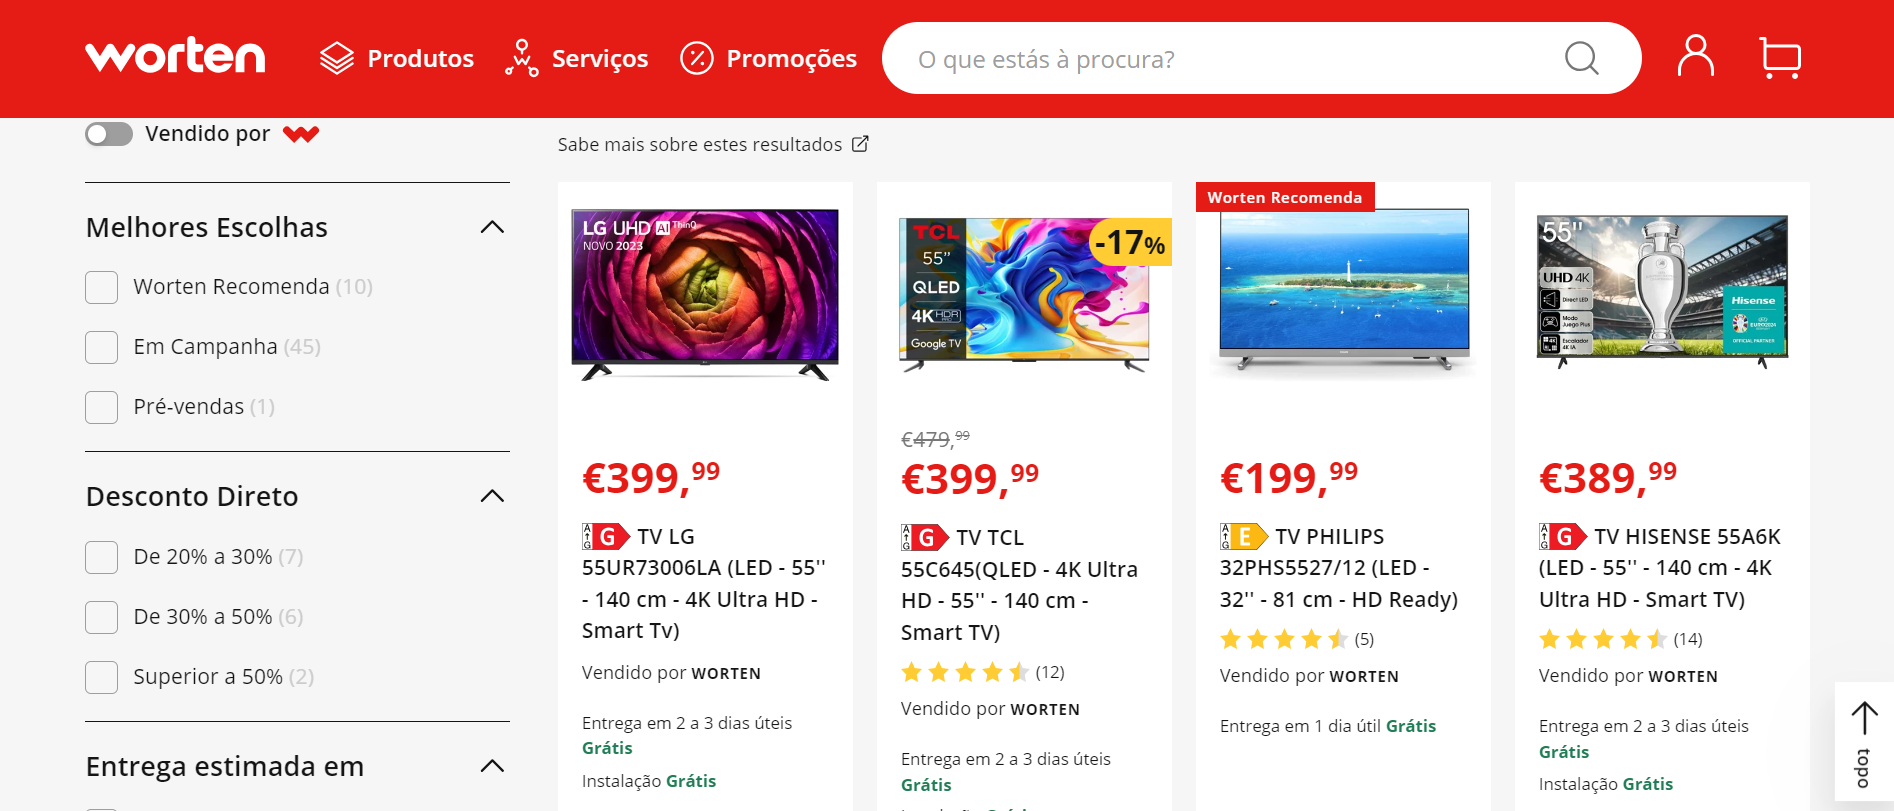

In [1]:
from IPython.display import Image
Image(filename='img/worten.png') 

Currently, their website is rendered using JavaScript, making it challenging to scrape data due to various anti-scraping measures they have in place. As a workaround, I manually downloaded all 12 pages of their online catalogue. You can find the raw HTML files for each page in the folder data/html. Although this process required approximately 1 minute, it seems reasonable considering the potential data yield from 542 TVs.

The task of collecting the raw data involves three main steps:

1. Finding the URL for Each Product's Page
2. Extracting the Data of Each TV
3. Consolidating All Data into a Single File

Let's begin by retrieving all the URLs.

In [3]:
from bs4 import BeautifulSoup
from typing import List


def parse_page_urls(html: str) -> List[str]:
	'''Returns list of product page URLs'''

	# Parse the content using beautifulsoup
	soup = BeautifulSoup(html, 'html.parser')

	# Now find all hyperlinks in each page
	links = soup.find_all("a")

	# Filter only the hyperlinks that refer to TVs
	return [link.get('href') for link in links if link.get('href').startswith('https://www.worten.pt/produtos/tv-')]

def parse_file_urls(path: str) -> List[str]:
	'''Returns a list of URLs parsed from a local HTML file'''

	# Get the content of each html page
	with open(path, 'r', encoding='utf8') as file:
		html = file.read()
	
	# Filter only the hyperlinks that refer to TVs
	return parse_page_urls(html)

# Loop over the 12 html pages of products
links = [link for i in range(12) for link in parse_file_urls(f'data/html/page{i+1}.html')]

# Save the links to a file for inspection
with open("data/links.txt", "w") as outfile:
	outfile.write("\n".join(links))

# Print summary
print(f'{len(links)} links found.')

525 links found.


Now, from each link we must extract the relevant information and put it in a structured way.

In [2]:
import logging
import requests
from bs4 import BeautifulSoup
import pandas as pd
from typing import Dict

# Create and configure logger
logging.basicConfig(
	filename = "data/debug.log",
	format = "%(asctime)s [%(levelname)s] %(message)s",
	filemode = 'w')

# Create a custom logger to prevent debugging info from imported modules
logger = logging.getLogger(__name__)

# Setting the threshold of logger to DEBUG
logger.setLevel(logging.DEBUG)

def get_tv_data(url: str) -> Dict:
	'''Returns a dictionary with TV specifications'''

	# Create a disguised header
	header = {
		"User-Agent": "Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/50.0.2661.75 Safari/537.36",
		"X-Requested-With": "XMLHttpRequest"
	}

	# Make the request
	r = requests.get(url, headers=header)

	# Parse each page
	soup = BeautifulSoup(r.content, 'html.parser')

	try:
		# Get the price of each TV
		price = float(soup.find("span", {"class": "integer"}).text) + float(soup.find("span", {"class": "decimal"}).text)/100
		
		# Get all tables on the page
		tables = pd.read_html(r.text)

		# Get all TV info as a dictionary
		tv_info = {attribute[0]:attribute[1] for table in tables for attribute in table.values.tolist()}

		# Add the price and URL of the TV to the info dict
		tv_info['price'] = price
		tv_info['URL'] = url

		# Write to the logger
		logger.info(f'Sucessfully scraped: {url}')
	
	except Exception as err:
		logger.error(f'Failed to scrape: {url}. ERROR: \n {err}')
		
		# Add the URL of the TV to the info dict
		tv_info = {'URL': url}

	# Print the current link
	print(r.status_code, url, end='\r')

	return tv_info

# Create a list with all TV data
data = [get_tv_data(url.strip()) for url in open('data/links.txt')]

# Empty print for closure
print()

# Use the data to create a pandas dataframe
df = pd.DataFrame.from_dict(data)

# Save the dataframe to excel for inspection and further analysis
df.to_excel('data/scraped_data.xlsx')

200 https://www.worten.pt/produtos/tv-kunft-k8447h43u-led-43-109-cm-4k-ultra-hd-android-tv-76964308271601695529495643037676


## 4. Data Cleaning

In the preceding section, we gathered all available attributes from each TV's webpage. The collected data has been stored in an Excel file named 'data/scraped_data.xlsx'.

Upon reviewing the log file, it was noted that approximately 10 URLs failed to be scraped out of a total of approximately 525. This failure rate is deemed acceptable, with some of the failures attributed to inaccessible pages.

The successfully scraped data underwent a meticulous yet essential manual cleaning process. This involved selecting only the potentially relevant features, parsing formatted data, and removing any extraneous characters. The outcome of this effort is presented in the Excel file 'data/cleaned_data.xlsx', which will be subjected to further analysis in the subsequent sections.

## 5. Data Visualization and Analysis

Let's begin by quickly examining the size and attributes of our dataset.

In [3]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Start by fetching the data
df = pd.read_excel('data/cleaned_data.xlsx')
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 525 entries, 0 to 524
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NUMBER                   525 non-null    int64  
 1   REFERENCE                512 non-null    object 
 2   EAN                      512 non-null    float64
 3   BRAND                    512 non-null    object 
 4   SERIES                   390 non-null    object 
 5   MODEL                    490 non-null    object 
 6   YEAR                     401 non-null    float64
 7   WIDTH (MM)               404 non-null    float64
 8   HEIGHT (MM)              404 non-null    float64
 9   THICKNESS (MM)           404 non-null    float64
 10  MASS (KG)                395 non-null    float64
 11  ENERGY EFFICIENCY        507 non-null    object 
 12  CONSUMPTION (kWh/1000h)  419 non-null    float64
 13  DIAGONAL (IN)            504 non-null    float64
 14  DIAGONAL (CM)            5

We have a dataset comprising 525 entries of TV data, each containing 21 attributes. Among these attributes, some hold greater relevance for our analysis. Specifically, the brand, thickness, mass, diagonal size, technology, resolution, and price are key factors of interest. Understanding how each attribute influences the others and, ultimately, the final price is straightforward.

However, it's imperative to acknowledge the presence of missing data, which warrants further examination as we delve deeper into the dataset.

In [4]:
df.isnull().sum()

NUMBER                       0
REFERENCE                   13
EAN                         13
BRAND                       13
SERIES                     135
MODEL                       35
YEAR                       124
WIDTH (MM)                 121
HEIGHT (MM)                121
THICKNESS (MM)             121
MASS (KG)                  130
ENERGY EFFICIENCY           18
CONSUMPTION (kWh/1000h)    106
DIAGONAL (IN)               21
DIAGONAL (CM)               21
TECHNOLOGY                  74
RESOLUTION                  60
Smart TV                    78
OS                         128
PRICE                       13
URL                          0
dtype: int64

Based on the summary provided above, it's evident that certain attributes are more complete than others within the dataset. However, despite variations in completeness, the available data is sufficient to extract relevant business insights.

Now, let's take a quick look at a statistical summary of the numerical data.

In [5]:
df.describe()

,NUMBER,EAN,YEAR,WIDTH (MM),HEIGHT (MM),THICKNESS (MM),MASS (KG),CONSUMPTION (kWh/1000h),DIAGONAL (IN),DIAGONAL (CM),Smart TV,PRICE
count,525.000000,5.120000e+02,401.000000,404.000000,404.000000,404.000000,395.000000,419.000000,504.000000,504.000000,447.000000,512.000000
mean,262.000000,7.568602e+12,2022.159601,1258.622030,729.512376,63.976193,19.645595,97.899761,54.420635,138.051587,0.959732,1351.959258
std,151.698715,1.642341e+12,1.074460,362.155154,209.143989,47.696227,12.320901,73.505294,16.954202,42.907053,0.196808,2157.662583
min,0.000000,3.527570e+12,2018.000000,547.000000,62.000000,1.123000,2.350000,16.000000,24.000000,61.000000,0.000000,101.000000
25%,131.000000,5.985848e+12,2022.000000,967.000000,564.000000,39.900000,9.800000,54.000000,43.000000,109.000000,1.000000,385.127500
50%,262.000000,8.718863e+12,2023.000000,1230.750000,711.500000,59.900000,16.800000,84.000000,55.000000,140.000000,1.000000,786.725000
75%,393.000000,8.806092e+12,2023.000000,1452.000000,844.500000,78.400000,27.350000,114.500000,65.000000,165.000000,1.000000,1499.900000
max,524.000000,9.120107e+12,2024.000000,2199.000000,1288.000000,571.000000,67.200000,844.000000,100.000000,254.000000,1.000000,26885.830000


This statistical data is certainly relevant, but interpreting it in its raw form can be challenging. Therefore, let's create a normalized boxplot of our numerical attributes for a clearer visualization.

<Axes: >

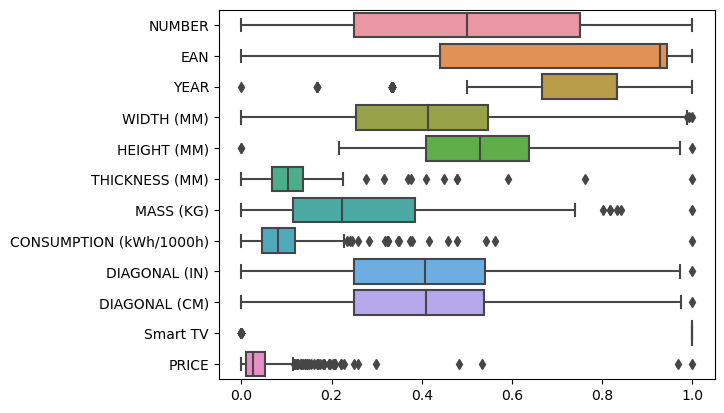

In [6]:
df_num = df.select_dtypes(include=np.number)
normalized_df = (df_num-df_num.min()) / (df_num.max()-df_num.min())
sns.boxplot(data=normalized_df, orient='h')

In the diagram above, it's particularly interesting to visually observe the prevalence of outliers in attributes such as thickness, energy consumption, and notably, price. This observation isn't surprising, as these attributes tend to exhibit a majority of values within a specific range, with only a few outliers that stand out significantly. Consider the following illustrative examples:

1. The majority of TVs today boast slim profiles. However, exceptionally inexpensive models may exhibit considerable thickness.
2. While most TVs are designed for low energy consumption, high-performance and gaming-oriented models tend to consume more energy.
3. The majority of TVs are priced below 1000€. However, it's not uncommon to encounter TVs priced above this threshold.

Now that we've gained some broad insights into these numerical attributes, let's delve deeper into the categorical attributes.

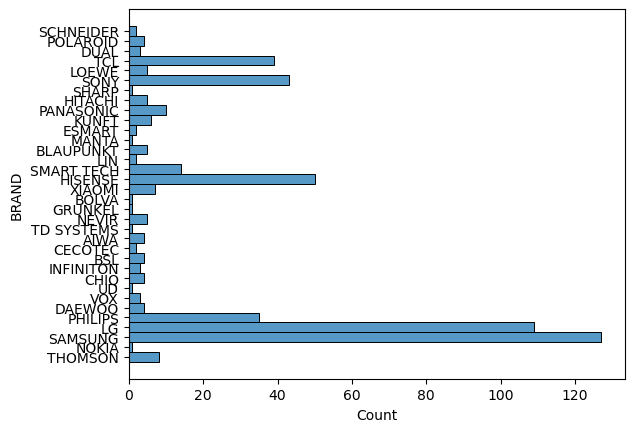

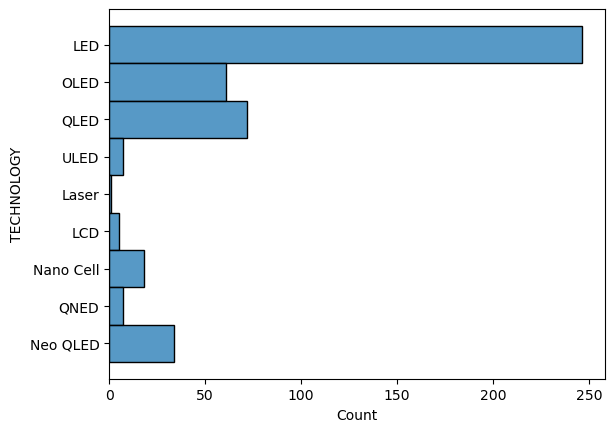

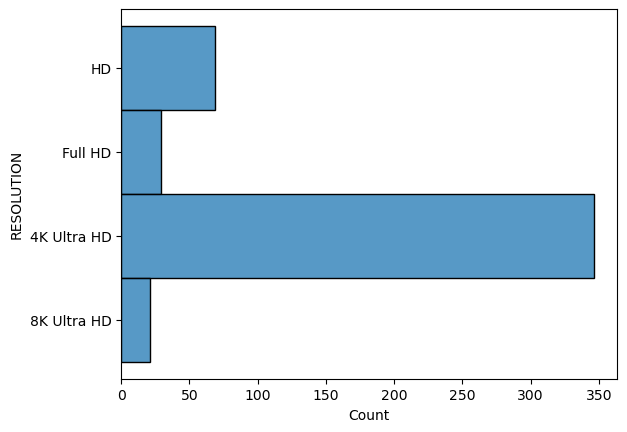

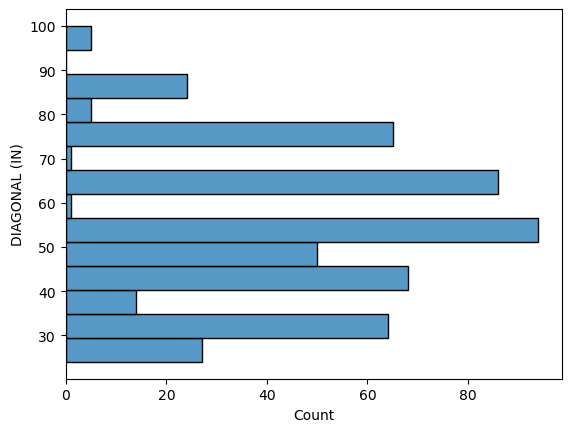

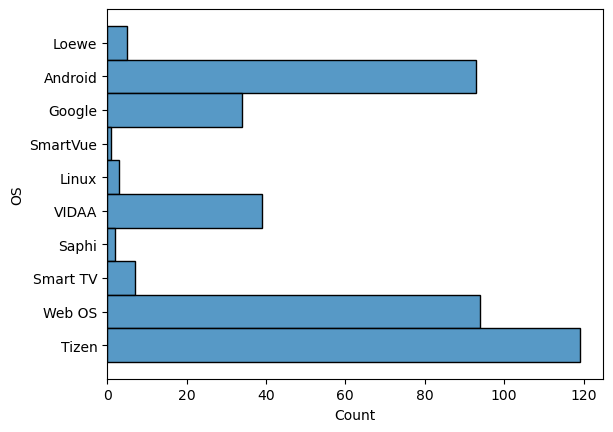

In [45]:
sns.histplot(data=df, y='BRAND')
plt.show()

sns.histplot(data=df, y='TECHNOLOGY')
plt.show()

sns.histplot(data=df, y='RESOLUTION')
plt.show()

sns.histplot(data=df, y='DIAGONAL (IN)')
plt.show()

sns.histplot(data=df, y='OS')
plt.show()

Based on the histograms provided, we can readily discern the primary market trends within these categorical variables:

1. Predominant manufacturers include Samsung, LG, and HiSense.
2. Leading screen technologies encompass LED, QLED, and OLED.
3. 4K Ultra HD stands out as the overwhelmingly dominant resolution.
4. Principal Operating Systems consist of Tizen (utilized by Samsung), Web OS, and Android.

A natural question arises: which technologies is each brand primarily investing in? Let's delve into this further.

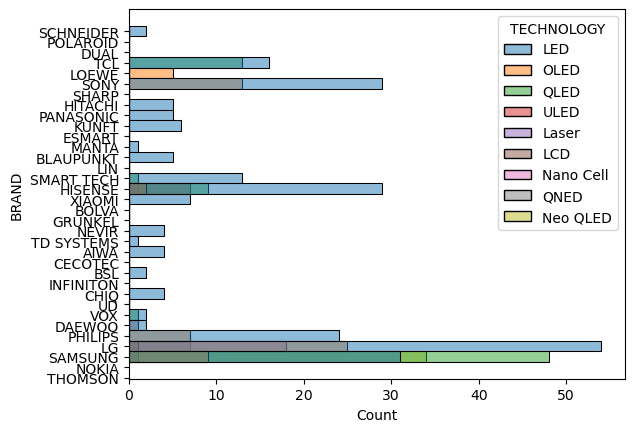

In [8]:
sns.histplot(data=df, y='BRAND', hue='TECHNOLOGY')
plt.show()

Based on the diagram provided, a notable issue within our dataset is evident: incomplete mapping, evident by the absence of certain data points. Consequently, drawing definitive conclusions becomes challenging, such as the assertion that LOEWE is the sole manufacturer of OLED, which appears highly improbable.

A proposed avenue for enhancing our dataset involves thorough validation and augmentation of all attributes, thereby ensuring comprehensive and accurate representation.

Now, let's try to find correlations between the numerical attributes using the multi grid plot tool.

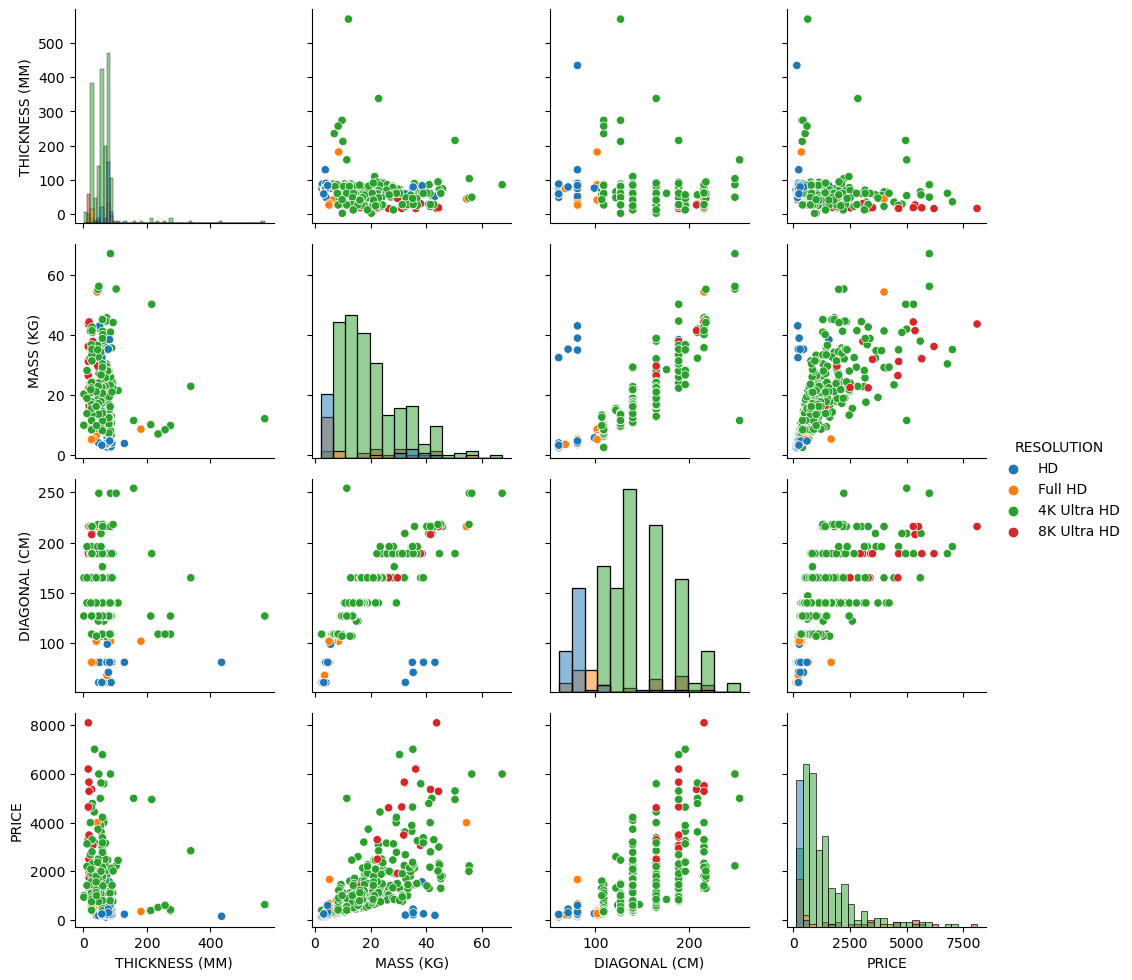

In [20]:
ax = sns.PairGrid(
    data=df[df['PRICE']<10000], 
    vars=['THICKNESS (MM)', 'MASS (KG)', 'DIAGONAL (CM)', 'PRICE'], 
    hue='RESOLUTION')
ax.map_diag(sns.histplot)
ax.map_offdiag(sns.scatterplot)
ax.add_legend()
plt.show()

By employing a color-coded representation based on resolution, this visualization technique enables us to discern intriguing clustering patterns, which illuminate the relationship between TV tiers and their physical attributes. Specifically, a clear distinction emerges: HD and 8K Ultra HD TVs are situated at opposite ends of the spectrum, with 4K Ultra HD occupying the intermediate position.

Moreover, it becomes evident that 8KUHD TVs are not only more costly but also boast a significantly larger diagonal screen size, remarkably slender profile, and comparatively heavier build.

Regarding the price, we can also analyse the values distribution in a boxplot and along a logarithmic axis, as the plot below shows.

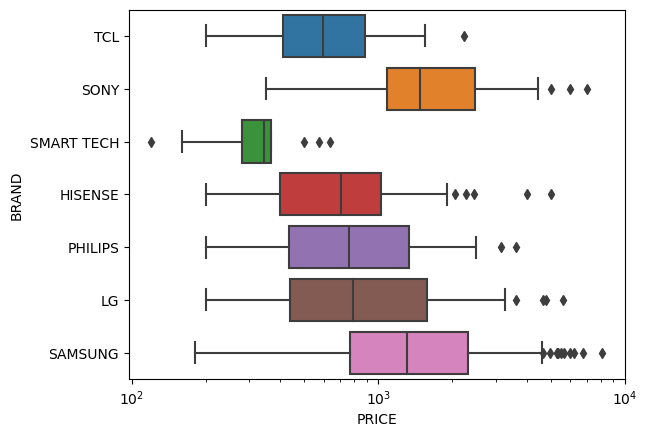

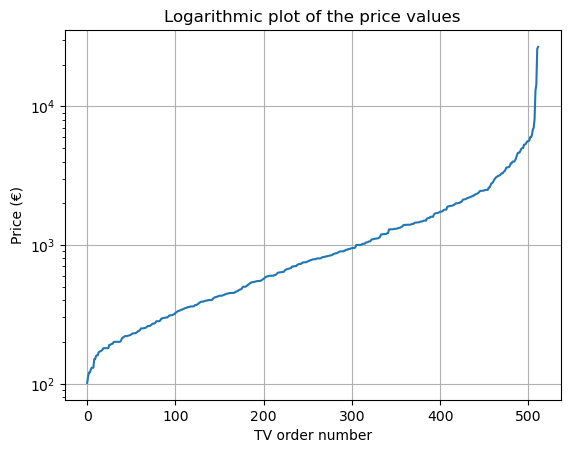

In [43]:
ax = sns.boxplot(
    data=df[(df['PRICE'] < 10000) & (df['BRAND'].map(df['BRAND'].value_counts()) > 10)], 
    x='PRICE', 
    y='BRAND', 
    orient='h')
ax.set_xscale('log')
plt.show()

ax = sns.lineplot(data=df.sort_values('PRICE').reset_index()['PRICE'])
ax.set_yscale('log')
ax.set_title('Logarithmic plot of the price values')
ax.set_xlabel('TV order number')
ax.set_ylabel("Price (€)")
ax.grid()
plt.show()

While a linear relationship is apparent in this data, with the exception of extreme values, I anticipate that this plot will remain open to future interpretation.

Moving on, I would like to present the heatmap below, illustrating the distribution of screen diagonal models across different brands.

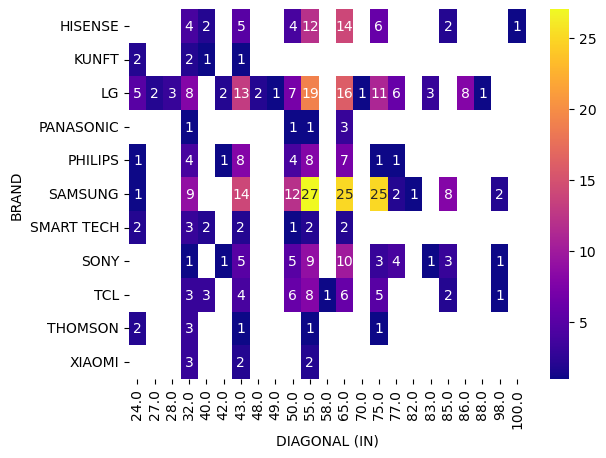

In [47]:
result = df[df['BRAND'].map(df['BRAND'].value_counts()) > 5]
result = pd.pivot_table(
    values ='PRICE', 
    index ='BRAND', 
    columns ='DIAGONAL (IN)', 
    data = result, 
    aggfunc=len) #, fill_value=0)

sns.heatmap(
    data=result,
    cmap ='plasma', 
    annot=True)
plt.show()

Based on the diagram provided, a compelling observation arises when comparing the strategies pursued by two major industry players, Samsung and LG. Samsung appears to concentrate its efforts on a select range of diagonal models, specifically the 55-inch, 65-inch, and 75-inch options. In contrast, LG has opted for a broader approach, offering a diverse array of screen sizes. This strategic diversity from LG potentially accommodates the varied size preferences of their customer base, catering to a wider range of needs.

## 6. Conclusion and Future Directions

This project serves as a demonstration of our ability to harness intricate insights from publicly available online data. It underscores the critical importance of utilizing appropriate tools in such endeavors. Throughout this endeavor, data scraping, meticulous data cleaning, comprehensive processing, and insightful visualization proved indispensable.

Referring to the objectives outlined at the beginning of this project, we can now provide some concluding insights:

1. Market Segmentation: It appears that TV resolution stands out as a key feature that effectively targets various consumer demographics.

2. Competitive Analysis: Sony positions itself as a premium brand, while LG focuses on diversification and Samsung places strong emphasis on specific models.

3. Brand Perception: Evaluating brand perception remains challenging, but future iterations of this project should consider incorporating average consumer ratings for a more comprehensive analysis.

4. Feature Preference: Determining consumer preferences for specific TV features is complex. However, analyzing it from a supply and demand perspective reveals that 4K Ultra HD 55-inch TVs are widely available, suggesting a strong consumer preference for this configuration.

5. Strategic Recommendations: Given the current state of TV technology, it seems unlikely that consumers will prioritize larger, thinner, or ultra-high-resolution TVs. Instead, the competitive edge is likely to be found in software features such as AI integration, and enhancing user experience despite increasing technological complexity.

Looking ahead, several avenues for improvement and future exploration emerge:

1. **Dataset Expansion**: Extend our analysis to encompass datasets from additional retailers, including FNAC and Media Markt, to provide a more comprehensive understanding of market trends.

2. **Data Quality Enhancement**: Enhance the quality and completeness of our datasets by implementing rigorous validation techniques and expanding the scope of data collection to ensure greater accuracy and reliability.

3. **Integration of Deep Learning Models**: Explore the integration of deep learning models to predict TV prices based on a broader array of features. This approach promises to offer more nuanced insights into pricing dynamics and consumer behavior in the television market.